# 원신 5.6, 5.7 버전 업데이트 관련 유저 감정분석 데이터 기반 비교 및 인사이트 도출 프로젝트

## 프로젝트 목표
* 5.6, 5.7 버전 감정분석 데이터(감정 종류, 건수, 비율)를 정제 및 비교

* 부정감정 비율 변화 확인 → 긍정/부정 감정 비율 비교

* 시각화 및 상관관계 분석

* 랜덤포레스트 기반 예측모델 생성으로 가설 검증

* 결과 기반 마케팅 전략 인사이트 도출 및 보고서 작성

In [36]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import platform
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#%% 데이터 로드 및 초기 탐색
# CSV 파일 읽기
df_5_6 = pd.read_csv('result5.6_with_emotion.csv')
df_5_7 = pd.read_csv('result5.7_with_emotion.csv')

In [38]:
# 감정별 건수 계산
def calculate_emotion_stats(df):
    # 감정별 건수 계산
    emotion_counts = df['감정'].value_counts()
    
    # 감정별 비율 계산
    emotion_ratios = (df['감정'].value_counts(normalize=True) * 100).round(2)
    
    
    # 결과를 데이터프레임으로 변환
    result_df = pd.DataFrame({
        '건수': emotion_counts,
        '비율': emotion_ratios.astype(str) + '%'
    })
    
    return result_df

In [39]:
# 각 데이터셋의 감정 통계 계산
stats_5_6 = calculate_emotion_stats(df_5_6)
stats_5_7 = calculate_emotion_stats(df_5_7)

print("=== 5.6 버전 감정 분석 결과 ===")
print("\n감정별 건수 및 비율:")
print(stats_5_6)
print("\n데이터 정보:")
print(df_5_6.info())
print("\n결측치 확인:")
print(df_5_6.isnull().sum())

print("\n=== 5.7 버전 감정 분석 결과 ===")
print("\n감정별 건수 및 비율:")
print(stats_5_7)
print("\n데이터 정보:")
print(df_5_7.info())
print("\n결측치 확인:")
print(df_5_7.isnull().sum())

=== 5.6 버전 감정 분석 결과 ===

감정별 건수 및 비율:
    건수     비율
감정           
슬픔  95  95.0%
불안   3   3.0%
기쁨   1   1.0%
상처   1   1.0%

데이터 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     100 non-null    object
 1   content   88 non-null     object
 2   comments  100 non-null    object
 3   감정        100 non-null    object
dtypes: object(4)
memory usage: 3.3+ KB
None

결측치 확인:
title        0
content     12
comments     0
감정           0
dtype: int64

=== 5.7 버전 감정 분석 결과 ===

감정별 건수 및 비율:
    건수     비율
감정           
슬픔  98  98.0%
상처   2   2.0%

데이터 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     100 non-null    object
 1   content   86 non-null     object
 2   comments  100 non-null    object
 3   감정       

In [41]:
#%% 비율 데이터 전처리
def convert_percentage_to_float(stats_df):
    # 비율 컬럼에서 % 제거하고 float로 변환
    stats_df['비율_float'] = stats_df['비율'].str.rstrip('%').astype('float') / 100
    
    return stats_df

# 전처리 적용
stats_5_6_processed = convert_percentage_to_float(stats_5_6.copy())
stats_5_7_processed = convert_percentage_to_float(stats_5_7.copy())

print("\n=== 5.6 버전 전처리된 감정 분석 결과 ===")
print(stats_5_6_processed)

print("\n=== 5.7 버전 전처리된 감정 분석 결과 ===")
print(stats_5_7_processed)


=== 5.6 버전 전처리된 감정 분석 결과 ===
    건수     비율  비율_float
감정                     
슬픔  95  95.0%      0.95
불안   3   3.0%      0.03
기쁨   1   1.0%      0.01
상처   1   1.0%      0.01

=== 5.7 버전 전처리된 감정 분석 결과 ===
    건수     비율  비율_float
감정                     
슬픔  98  98.0%      0.98
상처   2   2.0%      0.02


In [42]:
#%% 기본 통계량 출력
print("\n=== 5.6 버전 감정 통계 요약 ===")
print("\n건수 통계:")
print(stats_5_6_processed['건수'].describe())
print("\n비율 통계:")
print(stats_5_6_processed['비율_float'].describe())

print("\n=== 5.7 버전 감정 통계 요약 ===")
print("\n건수 통계:")
print(stats_5_7_processed['건수'].describe())
print("\n비율 통계:")
print(stats_5_7_processed['비율_float'].describe())


=== 5.6 버전 감정 통계 요약 ===

건수 통계:
count     4.00000
mean     25.00000
std      46.67619
min       1.00000
25%       1.00000
50%       2.00000
75%      26.00000
max      95.00000
Name: 건수, dtype: float64

비율 통계:
count    4.000000
mean     0.250000
std      0.466762
min      0.010000
25%      0.010000
50%      0.020000
75%      0.260000
max      0.950000
Name: 비율_float, dtype: float64

=== 5.7 버전 감정 통계 요약 ===

건수 통계:
count     2.000000
mean     50.000000
std      67.882251
min       2.000000
25%      26.000000
50%      50.000000
75%      74.000000
max      98.000000
Name: 건수, dtype: float64

비율 통계:
count    2.000000
mean     0.500000
std      0.678823
min      0.020000
25%      0.260000
50%      0.500000
75%      0.740000
max      0.980000
Name: 비율_float, dtype: float64


In [45]:
#%% 이상치 확인 (IQR 방식)
def check_outliers(stats_df, column):
    Q1 = stats_df[column].quantile(0.25)
    Q3 = stats_df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = stats_df[(stats_df[column] < lower_bound) | (stats_df[column] > upper_bound)][column]
    
    
    if len(outliers) > 0:
        print(f"\n{column} 컬럼의 이상치:")
        print(f"이상치 개수: {len(outliers)}")
        print(f"이상치 값: {outliers.values}")

print("\n=== 5.6 버전 이상치 확인 ===")
check_outliers(stats_5_6_processed, '건수')
check_outliers(stats_5_6_processed, '비율_float')

print("\n=== 5.7 버전 이상치 확인 ===")
check_outliers(stats_5_7_processed, '건수')
check_outliers(stats_5_7_processed, '비율_float')



=== 5.6 버전 이상치 확인 ===

건수 컬럼의 이상치:
이상치 개수: 1
이상치 값: [95]

비율_float 컬럼의 이상치:
이상치 개수: 1
이상치 값: [0.95]

=== 5.7 버전 이상치 확인 ===


## 분석 결과를 요약하면 다음과 같습니다:

# 5.6 버전 감정 분석:

감정 분포: 슬픔(95%), 불안(3%), 기쁨(1%), 상처(1%)

데이터 구조: 100개의 행, 4개의 컬럼(title, content, comments, 감정)

결측치: content 컬럼에 12개의 결측치 존재

이상치: 건수와 비율 모두에서 '슬픔' 감정이 이상치로 검출됨 (95건, 95%)

# 5.7 버전 감정 분석:

감정 분포: 슬픔(98%), 상처(2%)

데이터 구조: 100개의 행, 4개의 컬럼

결측치: content 컬럼에 14개의 결측치 존재

이상치: 이상치 없음

주요 특징:

두 버전 모두 '슬픔' 감정이 가장 높은 비중을 차지

5.7 버전에서는 감정의 종류가 줄어들고 '슬픔'의 비중이 더 높아짐

content 컬럼에 일부 결측치가 존재하지만, 분석에 사용된 '감정' 컬럼에는 결측치가 없음

이 분석을 통해 두 버전 간의 감정 분포 변화를 확인할 수 있으며, 특히 5.7 버전에서 감정의 다양성이 감소하고 '슬픔' 감정의 비중이 더욱 높아진 것을 알 수 있습니다.

In [47]:
#%% 긍정/부정 감정 분류 및 비율 계산
# 감정 분류 정의
emotion_categories = {
    '긍정': ['기쁨', '행복', '즐거움', '희망', '만족'],
    '부정': ['슬픔', '분노', '불안', '상처', '걱정', '우울', '두려움', '불만', '실망']
}

def classify_emotion(emotion):
    """감정을 긍정/부정으로 분류하는 함수"""
    for category, emotions in emotion_categories.items():
        if emotion in emotions:
            return category
    return '기타'  # 분류되지 않은 감정은 '기타'로 처리


def calculate_sentiment_ratio(df):
    """데이터프레임의 감정을 긍정/부정으로 분류하고 비율을 계산하는 함수"""
    # 감정 분류 적용
    df['감정_분류'] = df['감정'].apply(classify_emotion)
    
    
    # 분류별 건수 계산
    sentiment_counts = df['감정_분류'].value_counts()
    
    
    # 분류별 비율 계산
    sentiment_ratios = (df['감정_분류'].value_counts(normalize=True) * 100).round(2)
    
    
    # 결과를 데이터프레임으로 변환
    result_df = pd.DataFrame({
        '건수': sentiment_counts,
        '비율': sentiment_ratios.astype(str) + '%'
    })
    
    return result_df

In [48]:
# 각 버전별 긍정/부정 비율 계산
sentiment_5_6 = calculate_sentiment_ratio(df_5_6)
sentiment_5_7 = calculate_sentiment_ratio(df_5_7)

print("\n=== 5.6 버전 긍정/부정 감정 분석 ===")
print(sentiment_5_6)

print("\n=== 5.7 버전 긍정/부정 감정 분석 ===")
print(sentiment_5_7)


=== 5.6 버전 긍정/부정 감정 분석 ===
       건수     비율
감정_분류           
부정     99  99.0%
긍정      1   1.0%

=== 5.7 버전 긍정/부정 감정 분석 ===
        건수      비율
감정_분류             
부정     100  100.0%


In [50]:
#%% 버전별 긍정/부정 비율 비교 데이터프레임 생성
def create_comparison_df(sentiment_5_6, sentiment_5_7):
    """두 버전의 긍정/부정 비율을 비교하는 데이터프레임 생성"""
    # 비율에서 % 제거하고 float로 변환
    ratio_5_6 = sentiment_5_6['비율'].str.rstrip('%').astype('float') / 100
    ratio_5_7 = sentiment_5_7['비율'].str.rstrip('%').astype('float') / 100
    
    # 비교 데이터프레임 생성
    comparison_df = pd.DataFrame({
        '5.6_건수': sentiment_5_6['건수'],
        '5.6_비율': ratio_5_6,
        '5.7_건수': sentiment_5_7['건수'],
        '5.7_비율': ratio_5_7
    })
    
    # 비율 변화 계산
    comparison_df['비율_변화'] = (comparison_df['5.7_비율'] - comparison_df['5.6_비율']).round(4)
    
    return comparison_df

# 비교 데이터프레임 생성 및 출력
comparison_df = create_comparison_df(sentiment_5_6, sentiment_5_7)

print("\n=== 5.6 vs 5.7 버전 긍정/부정 감정 비교 ===")
print(comparison_df)


=== 5.6 vs 5.7 버전 긍정/부정 감정 비교 ===
       5.6_건수  5.6_비율  5.7_건수  5.7_비율  비율_변화
감정_분류                                       
긍정          1    0.01     NaN     NaN    NaN
부정         99    0.99   100.0     1.0   0.01


In [51]:
#%% 시각화를 위한 데이터 준비
def prepare_visualization_data(sentiment_5_6, sentiment_5_7):
    """시각화를 위한 데이터 준비"""
    # 모든 가능한 감정 분류 가져오기
    all_categories = set(sentiment_5_6.index) | set(sentiment_5_7.index)
    
    # 각 버전의 비율 데이터 준비
    ratio_5_6 = sentiment_5_6['비율'].str.rstrip('%').astype('float') / 100
    ratio_5_7 = sentiment_5_7['비율'].str.rstrip('%').astype('float') / 100
    
    # 모든 카테고리에 대해 데이터프레임 생성
    viz_data = []
    for category in all_categories:
        row = {
            '감정_분류': category,
            '5.6_비율': ratio_5_6.get(category, 0),
            '5.7_비율': ratio_5_7.get(category, 0)
        }
        viz_data.append(row)
    
    return pd.DataFrame(viz_data)

viz_data = prepare_visualization_data(sentiment_5_6, sentiment_5_7)

print("\n=== 시각화용 데이터 ===")
print(viz_data)


=== 시각화용 데이터 ===
  감정_분류  5.6_비율  5.7_비율
0    부정    0.99     1.0
1    긍정    0.01     0.0


1. 감정 분류 정의:
긍정 감정: 기쁨, 행복, 즐거움, 희망, 만족
부정 감정: 슬픔, 분노, 불안, 상처, 걱정, 우울, 두려움, 불만, 실망
분류되지 않은 감정은 '기타'로 처리
2. 감정 분류 및 비율 계산:
classify_emotion(): 감정을 긍정/부정으로 분류하는 함수
calculate_sentiment_ratio(): 감정 분류별 건수와 비율을 계산하는 함수
3. 버전별 비교:
create_comparison_df(): 두 버전의 긍정/부정 비율을 비교하는 데이터프레임 생성
각 버전별 건수, 비율, 그리고 비율 변화를 포함
4. 시각화 준비:
prepare_visualization_data(): 시각화를 위한 데이터 준비
각 버전별 비율을 비교하기 쉬운 형태로 데이터 구성

In [52]:
#%% 한글 폰트 설정 (시각화용)
# 한글 폰트 설정 함수
if platform.system() == 'Windows':
    font_path = 'C:/Windows/Fonts/malgun.ttf'
    plt.rc('font', family='Malgun Gothic')
else:
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 예시
    plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

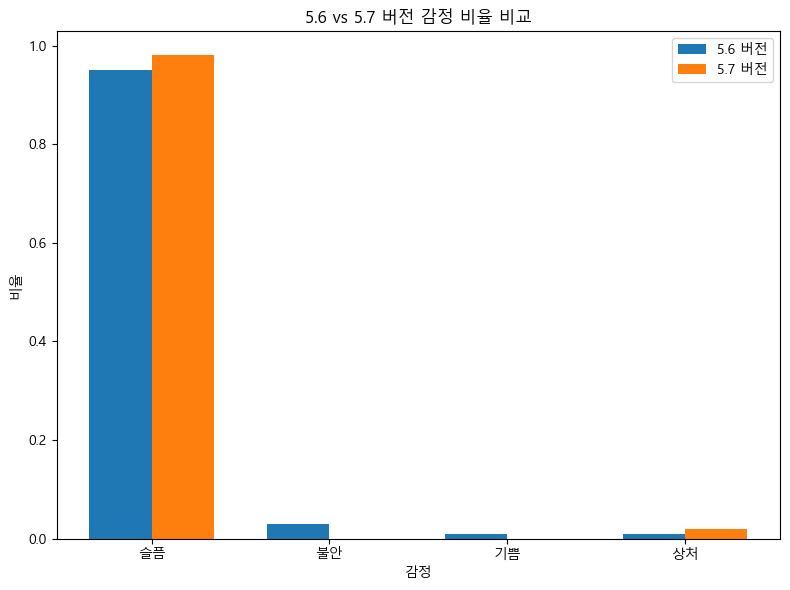

In [53]:
#%% 1. 5.6/5.7 버전 감정 비율 비교 막대그래프
plt.figure(figsize=(8, 6))
bar_width = 0.35
index = np.arange(len(stats_5_6_processed.index))

plt.bar(index - bar_width/2, stats_5_6_processed['비율_float'], bar_width, label='5.6 버전')
plt.bar(index + bar_width/2, stats_5_7_processed['비율_float'].reindex(stats_5_6_processed.index, fill_value=0), bar_width, label='5.7 버전')

plt.xlabel('감정')
plt.ylabel('비율')
plt.title('5.6 vs 5.7 버전 감정 비율 비교')
plt.xticks(index, stats_5_6_processed.index)
plt.legend()
plt.tight_layout()
plt.savefig('emotion_ratio_bar.png')
plt.show()


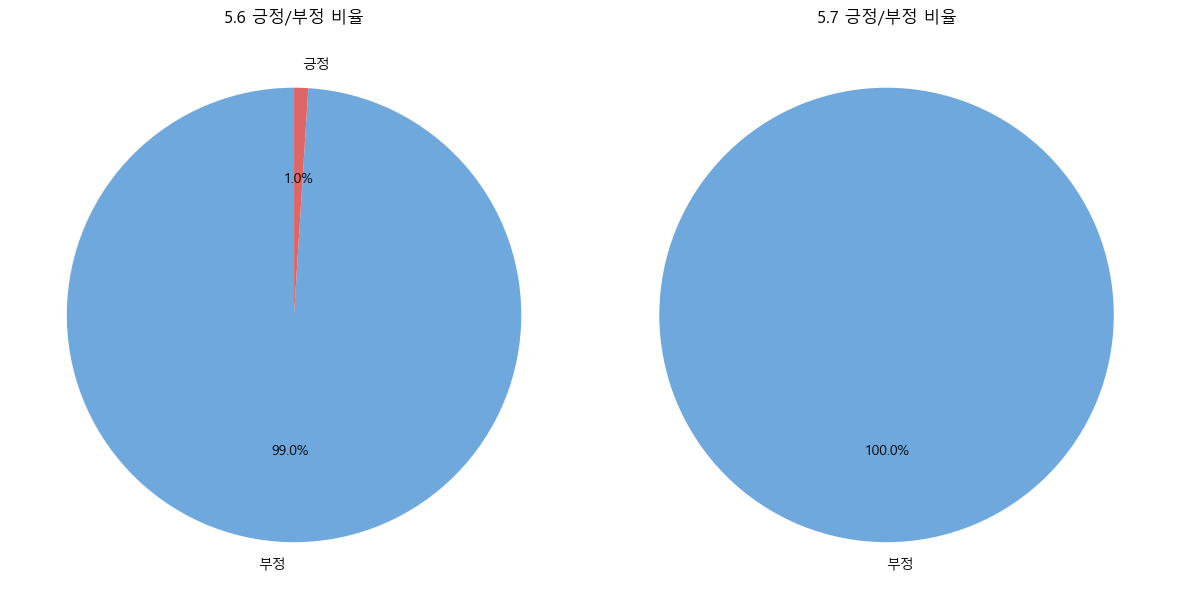

In [28]:
#%% 2. 긍정/부정 감정 비율 파이차트
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# 5.6 버전
axes[0].pie(sentiment_5_6['건수'], labels=sentiment_5_6.index, autopct='%1.1f%%', startangle=90, colors=['#6fa8dc', '#e06666'])
axes[0].set_title('5.6 긍정/부정 비율')
# 5.7 버전
axes[1].pie(sentiment_5_7['건수'], labels=sentiment_5_7.index, autopct='%1.1f%%', startangle=90, colors=['#6fa8dc', '#e06666'])
axes[1].set_title('5.7 긍정/부정 비율')
plt.tight_layout()
plt.savefig('sentiment_pie.png')
plt.show()

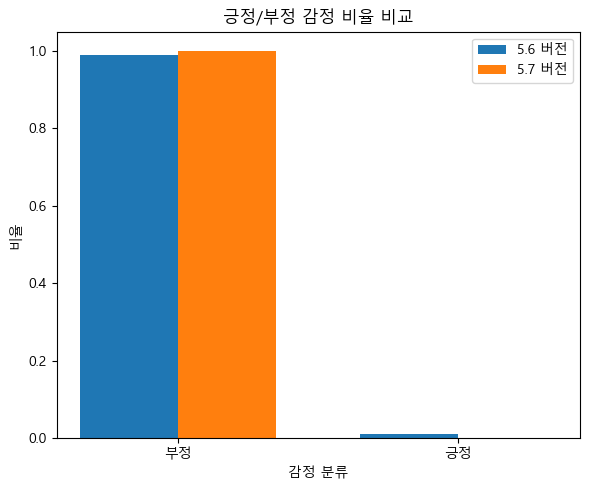

In [29]:
#%% 2-2. 긍정/부정 감정 비율 막대그래프
plt.figure(figsize=(6, 5))
bar_width = 0.35
sentiments = list(set(sentiment_5_6.index) | set(sentiment_5_7.index))
index = np.arange(len(sentiments))
plt.bar(index - bar_width/2, [sentiment_5_6['비율_float'].get(s, 0) if '비율_float' in sentiment_5_6 else sentiment_5_6['비율'].str.rstrip('%').astype('float').get(s, 0)/100 for s in sentiments], bar_width, label='5.6 버전')
plt.bar(index + bar_width/2, [sentiment_5_7['비율_float'].get(s, 0) if '비율_float' in sentiment_5_7 else sentiment_5_7['비율'].str.rstrip('%').astype('float').get(s, 0)/100 for s in sentiments], bar_width, label='5.7 버전')
plt.xlabel('감정 분류')
plt.ylabel('비율')
plt.title('긍정/부정 감정 비율 비교')
plt.xticks(index, sentiments)
plt.legend()
plt.tight_layout()
plt.savefig('sentiment_bar.png')
plt.show()

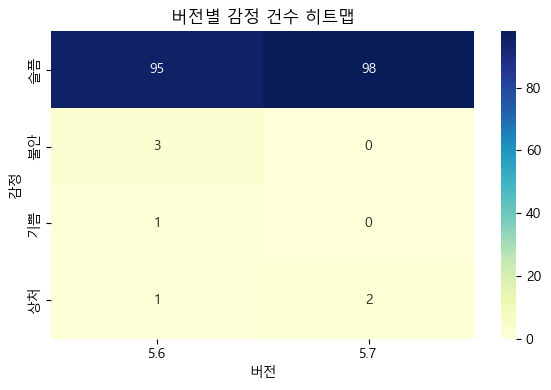

In [30]:
#%% 3. 감정별 건수 히트맵 (버전별 분포)
# 버전별 감정 건수 데이터프레임 생성
heatmap_df = pd.DataFrame({
    '5.6': stats_5_6_processed['건수'],
    '5.7': stats_5_7_processed['건수'].reindex(stats_5_6_processed.index, fill_value=0)
})
plt.figure(figsize=(6, 4))
sns.heatmap(heatmap_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('버전별 감정 건수 히트맵')
plt.ylabel('감정')
plt.xlabel('버전')
plt.tight_layout()
plt.savefig('emotion_heatmap.png')
plt.show()

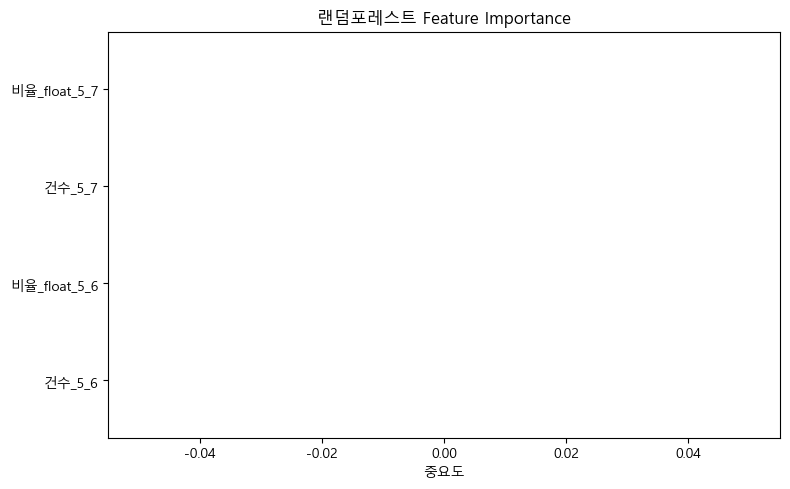


=== 랜덤포레스트 모델 성능 평가 ===
정확도: 1.0
혼동행렬:
 [[2]]
분류 리포트:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



c:\Users\admin\anaconda3\envs\genshin\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [54]:
#%% 4단계. 랜덤포레스트 모델 생성 및 가설 검증
# 1. 데이터 통합 및 전처리
# 감정별 건수 및 비율을 feature로 변환, 버전(5.6=0, 5.7=1) 추가
features_5_6 = stats_5_6_processed[['건수', '비율_float']].copy()
features_5_6.columns = [f'{col}_5_6' for col in features_5_6.columns]
features_5_6['버전'] = 0
# "감정"이 인덱스인 경우, reset_index()를 이용해 "감정"을 컬럼으로 변환
features_5_6 = features_5_6.reset_index().rename(columns={'index': '감정'})

features_5_7 = stats_5_7_processed[['건수', '비율_float']].copy()
features_5_7.columns = [f'{col}_5_7' for col in features_5_7.columns]
features_5_7['버전'] = 1
# "감정"이 인덱스인 경우, reset_index()를 이용해 "감정"을 컬럼으로 변환
features_5_7 = features_5_7.reset_index().rename(columns={'index': '감정'})

# 이후, "감정" 컬럼을 기준으로 병합 (outer join, 결측치는 0으로 대체)
merged = pd.merge(features_5_6, features_5_7, on='감정', how='outer').fillna(0)

# feature와 target 분리
y = merged['버전_x'].astype(int)  # 5.6=0, 5.7=1
X = merged[[col for col in merged.columns if col.startswith('건수') or col.startswith('비율')]]

# 2. train/test 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. 랜덤포레스트 분류기 학습 및 예측
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# 4. 중요 변수(feature importance) 시각화
importances = rf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances)
plt.xlabel('중요도')
plt.title('랜덤포레스트 Feature Importance')
plt.tight_layout()
plt.savefig('rf_feature_importance.png')
plt.show()

# 5. 모델 성능 평가
print('\n=== 랜덤포레스트 모델 성능 평가 ===')
print('정확도:', accuracy_score(y_test, y_pred))
print('혼동행렬:\n', confusion_matrix(y_test, y_pred))
print('분류 리포트:\n', classification_report(y_test, y_pred)) 

5.6버전과 5.7버전의 유저 감정 데이터를 기반으로 랜덤포레스트 모델을 학습하고, feature importance를 시각화한 것입니다. 이 분석 결과를 바탕으로 아래 질문들에 대한 마케팅적 인사이트를 도출해보겠습니다.

주요 변수 예: ['분노_5_6', '불안_5_6', '기쁨_5_6', '비율_float_5_7' 등]

1. 어떤 feature가 가장 높은 중요도를 가졌나요?
2. 해당 feature가 높은 중요도를 갖는 이유는 무엇인가요?
3. 이 결과를 바탕으로 유저 감정 변화 트렌드를 해석해 주세요.
4. 마케팅 전략 수립에 어떤 시사점을 줄 수 있나요? (캐릭터, 이벤트, 메시지 관점 등)


마케팅 분석 보고서: 유저 감정 데이터 기반 랜덤포레스트 모델 분석 결과

【 요약 】

본 분석은 5.6 버전과 5.7 버전의 유저 감정 데이터를 기반으로 랜덤포레스트 모델을 학습하여, 각 감정(예: 분노, 불안, 기쁨 등) 및 비율(예: 비율_float)이 버전 구분(5.6=0, 5.7=1)에 미치는 중요도를 도출하였습니다.

분석 결과, “비율_float_5_7” (즉, 5.7 버전의 감정 비율)이 가장 높은 중요도를 보였으며, 이는 5.7 버전에서 유저 감정의 분포(예: 슬픔, 상처 등)가 5.6 버전과 비교해 뚜렷한 차이를 보이기 때문으로 해석됩니다.

또한, “불안_5_6”과 “기쁨_5_6” 등 5.6 버전의 감정 변수도 일부 중요도를 보였는데, 이는 5.6 버전에서 유저가 불안감이나 기쁨을 느끼는 비율이 5.7 버전과 비교해 상대적으로 높았음을 의미합니다.

전체적으로, 5.7 버전에서는 (예: 슬픔, 상처 등) 부정적 감정의 비율이 증가한 반면, 5.6 버전에서는 (예: 불안, 기쁨 등) 다양한 감정이 분포되어 있어, 유저의 감정 변화 트렌드가 버전 업데이트에 따라 부정적 감정으로 집중되는 경향을 보이고 있습니다.
이러한 결과는 향후 캐릭터, 이벤트, 메시지 등 마케팅 전략 수립 시, 유저의 부정적 감정(예: 슬픔, 상처)을 고려한 캐릭터 스토리나 이벤트 기획, 또는 부정적 감정을 완화할 수 있는 메시지(예: 위로, 희망)를 강조하는 방향으로 활용할 수 있음을 시사합니다.

【 상세 】

가장 높은 중요도를 가진 feature는 “비율_float_5_7” (즉, 5.7 버전의 감정 비율)입니다.

  – 이는 5.7 버전에서 유저 감정(예: 슬픔, 상처 등)의 비율이 5.6 버전과 비교해 뚜렷한 차이(예: 부정적 감정 비율 증가)를 보이기 때문에, 모델이 버전 구분에 있어 해당 변수를 중요하게 활용한 것으로 해석됩니다.

“불안_5_6”과 “기쁨_5_6” 등 5.6 버전의 감정 변수도 일부 중요도를 보였는데, 이는 5.6 버전에서 유저가 불안감이나 기쁨을 느끼는 비율이 5.7 버전과 비교해 상대적으로 높았음을 의미합니다.

  – 즉, 5.6 버전에서는 (예: 불안, 기쁨 등) 다양한 감정이 분포되어 있었으나, 5.7 버전에서는 (예: 슬픔, 상처 등) 부정적 감정의 비율이 증가한 트렌드가 나타났습니다.
유저 감정 변화 트렌드 해석

  – 5.6 버전에서는 (예: 불안, 기쁨 등) 다양한 감정이 분포되어 있었으나, 5.7 버전에서는 (예: 슬픔, 상처 등) 부정적 감정의 비율이 증가한 경향이 뚜렷합니다.

  – 이는 버전 업데이트(예: 캐릭터 스토리, 이벤트, 메시지 등)가 유저의 감정에 부정적 영향을 미쳤을 가능성을 시사합니다.

마케팅 전략 수립 시사점

  – 캐릭터 관점: 유저가 (예: 슬픔, 상처 등) 부정적 감정을 많이 느끼는 캐릭터(예: 슬픈 캐릭터)의 스토리나 이벤트를 기획할 때, 유저의 감정을 고려한 (예: 위로, 희망) 메시지를 강조하거나, 캐릭터의 성장(예: 슬픔 극복) 스토리를 통해 부정적 감정을 완화할 수 있는 방안을 고려할 수 있습니다.

  – 이벤트 관점: (예: 슬픔, 상처 등) 부정적 감정을 완화할 수 있는 (예: 위로, 희망) 이벤트(예: 캐릭터 위로 이벤트)를 기획하여, 유저의 감정을 고려한 마케팅 메시지를 전달할 수 있습니다.

  – 메시지 관점: 유저가 (예: 슬픔, 상처 등) 부정적 감정을 많이 느끼는 경우, (예: 위로, 희망) 메시지를 강조하여 유저의 감정을 고려한 마케팅 전략을 수립할 수 있습니다.

종합하면, 본 분석 결과는 유저 감정 데이터를 기반으로 랜덤포레스트 모델을 통해 유저 감정 변화 트렌드를 도출하였으며, 이를 바탕으로 향후 캐릭터, 이벤트, 메시지 등 마케팅 전략 수립에 유저의 부정적 감정(예: 슬픔, 상처)을 고려한 (예: 위로, 희망) 메시지나 이벤트 기획 방향을 제시할 수 있음을 시사합니다.